# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import StringIndexer, OneHotEncoder, MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# load the dataset 
df = spark.read.json("mini_sparkify_event_data.json")
# check the schema of the dataset
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
print("The dataframe has {} rows.".format(df.count()))

The dataframe has 286500 rows.


In [5]:
# display the Spark dataframe
df.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


* Note that converting a Spark dataframe to a Pandas one here is for display purpose only. This is not recommended when one has to deal with fairly large dataframes (If this is the case, use the following configuration will help: spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true") ), as Pandas needs to load all the data into memory. See https://stackoverflow.com/questions/39067505/pyspark-display-a-spark-data-frame-in-a-table-format.

#### Check values for categorical variables of interest

In [6]:
df.select('auth').distinct().collect()

[Row(auth='Logged Out'),
 Row(auth='Cancelled'),
 Row(auth='Guest'),
 Row(auth='Logged In')]

In [7]:
df.select('gender').distinct().collect()

[Row(gender='F'), Row(gender=None), Row(gender='M')]

In [8]:
df.select('level').distinct().collect()

[Row(level='free'), Row(level='paid')]

In [9]:
df.select('method').distinct().collect()

[Row(method='PUT'), Row(method='GET')]

In [10]:
df.select('page').distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

#### Check duration of records

In [11]:
df.select(min(to_timestamp(col('ts')/1000)).alias('Start time')).show()

+-------------------+
|         Start time|
+-------------------+
|2018-10-01 00:01:57|
+-------------------+



In [12]:
df.select(max(to_timestamp(col('ts')/1000)).alias('End time')).show()

+-------------------+
|           End time|
+-------------------+
|2018-12-03 01:11:16|
+-------------------+



The duration of records is about 2 months.

#### Check null values

In [13]:
# check the count of null values for each column
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


We can see that variables with null values can be divided into two groups, i.e.:

* Group 1 (user-related): firstName, gender, lastName, location, registration and userAgent
* Group 2 (song-related): artist, length and song

Variables in each group seem to be tied in a certain way with nulls.

In [14]:
df.where('firstName is null').toPandas().head(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged Out,None,None,100,None,None,free,None,GET,Home,None,8,None,200,1538355745000,None,
1,None,Logged Out,None,None,101,None,None,free,None,GET,Help,None,8,None,200,1538355807000,None,
2,None,Logged Out,None,None,102,None,None,free,None,GET,Home,None,8,None,200,1538355841000,None,
3,None,Logged Out,None,None,103,None,None,free,None,PUT,Login,None,8,None,307,1538355842000,None,
4,None,Logged Out,None,None,2,None,None,free,None,GET,Home,None,240,None,200,1538356678000,None,
5,None,Logged Out,None,None,3,None,None,free,None,PUT,Login,None,240,None,307,1538356679000,None,
6,None,Logged Out,None,None,0,None,None,free,None,PUT,Login,None,100,None,307,1538358102000,None,
7,None,Logged Out,None,None,0,None,None,free,None,PUT,Login,None,241,None,307,1538360117000,None,
8,None,Logged Out,None,None,14,None,None,free,None,GET,Home,None,187,None,200,1538361527000,None,
9,None,Logged Out,None,None,15,None,None,free,None,PUT,Login,None,187,None,307,1538361528000,None,


It can be seen that when **auth** is *LoggedOut*, variables in both groups are null and **userId** is an empty string. 

In [15]:
df.where(df['userId'] == '').groupBy('auth').count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 8249|
|     Guest|   97|
+----------+-----+



The result above shows all the rows with missing values in the **userId** column and all other user-related columns correspond to *Logged Out* or *Guest* authentication levels.

In [16]:
df.where('artist is null').toPandas().head(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Colin,M,54,Freeman,None,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,None,Logged In,Micah,M,84,Long,None,free,"Boston-Cambridge-Newton, MA-NH",GET,Roll Advert,1.538332e+12,8,None,200,1538353150000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,None,Logged In,Micah,M,86,Long,None,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1.538332e+12,8,None,307,1538353376000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
3,None,Logged In,Alexi,F,4,Warren,None,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1.532483e+12,53,None,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
4,None,Logged In,Alexi,F,7,Warren,None,paid,"Spokane-Spokane Valley, WA",PUT,Thumbs Up,1.532483e+12,53,None,307,1538355255000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
5,None,Logged In,Micah,M,95,Long,None,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Down,1.538332e+12,8,None,307,1538355306000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,None,Logged In,Micah,M,97,Long,None,free,"Boston-Cambridge-Newton, MA-NH",GET,Home,1.538332e+12,8,None,200,1538355504000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,None,Logged In,Micah,M,99,Long,None,free,"Boston-Cambridge-Newton, MA-NH",PUT,Logout,1.538332e+12,8,None,307,1538355687000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
8,None,Logged In,Ashlynn,F,9,Williams,None,free,"Tallahassee, FL",PUT,Thumbs Up,1.537365e+12,217,None,307,1538355711000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",74
9,None,Logged Out,None,None,100,None,None,free,None,GET,Home,NaN,8,None,200,1538355745000,None,


In [17]:
set(df.select('page').distinct().collect())-set(df.select('page').where('artist is null').distinct().collect())

{Row(page='NextSong')}

We find that the variables in Group 2 are null whenever **page** is not *NextSong*, which makes sense since these variables are song-related.

In [18]:
def clean_data(df):
    """Clean a Sparkify dataset in the form of the Spark dataframe 
    
    Args:
    df: a Sparkify dataset
    
    Returns:
    df: a preprocessed Sparkify dataset
    """
    # remove user id with empty strings
    df = df.filter(col('userId') != '')
    
    # convert 'registration' and 'ts' to date format
    df = df \
        .withColumn('registrationTime', to_timestamp(col('registration')/1000)) \
        .withColumn('time', to_timestamp(col('ts')/1000)) 
    
    # replace location with extracted state 
    df = df \
        .withColumn('location', split(col('location'),',').getItem(1)) \
        .withColumn('location', split(col('location'), '-').getItem(0))
        
    return df

df = clean_data(df)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [19]:
userWindow = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)

In [20]:
# label churned users to be 1 and unchurned users to be 0 
df = df \
    .withColumn('Churn', when(col('page')=='Cancellation Confirmation', 1).otherwise(0)) \
    .withColumn('Churn', max('Churn').over(userWindow))

In [21]:
df.dropDuplicates(['userId']).groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



There are 52 churned users in a total of 225 users in the dataset. That's about 23.1% churn rate. 

Next, we investigate the following factors for churn:
* gender
* location
* latest level
* registration duration
* average session duration
* aggregated activities / observation period

In [22]:
# find the latest level of each user
df = df.withColumn('latestLevel', last(col('level')).over(userWindow))

In [23]:
# calculate the number of days between registration to last activity 
df = df.withColumn('registDuration', ((last(col('ts')).over(userWindow)-col('registration'))/1000/3600/24).cast(IntegerType()))

In [24]:
# compute average session duration (in hours)
avg_session_duration_df = df \
    .groupby(['userId', 'sessionId']).agg(min(col('ts')).alias('session_start'), max(col('ts')).alias('session_end'))\
    .groupby('userId').agg(avg((col('session_end') - col('session_start'))/1000/3600).alias('avgSessionDuration'))

In [25]:
# define the default start and end of the observation period
obs_start_default = df.select(min(col('ts'))).collect()[0][0]
obs_end_default = df.select(max(col('ts'))).collect()[0][0]

In [26]:
# list users who registered after the start of the observation period
df.where(df['registration'] > obs_start_default).select(['userId','registrationTime']).dropDuplicates().show()

+------+-------------------+
|userId|   registrationTime|
+------+-------------------+
|   156|2018-11-26 15:49:14|
|   153|2018-11-03 05:42:17|
|   154|2018-11-03 18:00:21|
|   155|2018-11-04 22:27:50|
|   152|2018-10-30 23:03:28|
+------+-------------------+



In [27]:
# compute the observation period
df = df \
    .withColumn('obs_start', when(col('registration') > obs_start_default, first(col('ts')).over(userWindow)) \
                .otherwise(obs_start_default)) \
    .withColumn('end_state', last(col('page')).over(userWindow)) \
    .withColumn('obs_end', when(col('end_state') == 'Cancellation Confirmation', last(col('ts')).over(userWindow)) \
                .otherwise(obs_end_default)) \
    .withColumn('obsDays', (col('obs_end') - col('obs_start'))/1000/3600/24)

In [28]:
df.groupBy('page').count().orderBy('count', ascending=False).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



In [29]:
# aggregate activity statistics
user_df = df.groupBy('userId') \
.agg(first(col('Churn')).alias('Churn'), \
     first(when(col('gender') == 'M', 1).otherwise(0)).alias('gender'), \
     first(col('location')).alias('location'), \
     first(when(col('latestLevel') == 'paid', 1).otherwise(0)).alias('latestLevel'), \
     first(col('registDuration')).alias('registDuration'), \
     first(col('obsDays')).alias('obsDays'), \
     sum(when(col('page') == 'NextSong', 1).otherwise(0)).alias('nSongs'), \
     sum(when(col('page') == 'Thumbs Up', 1).otherwise(0)).alias('nThumbsUp'), \
     sum(when(col('page') == 'Thumbs Down', 1).otherwise(0)).alias('nThumbsDown'), \
     sum(when((col('page') == 'Upgrade') | (col('page') == 'Submit Upgrade'), 1).otherwise(0)).alias('nUpgrade'), \
     sum(when((col('page') == 'Downgrade') | (col('page') == 'Submit Downgrade'), 1).otherwise(0)).alias('nDowngrade'), \
     sum(when(col('page') == 'Add Friend', 1).otherwise(0)).alias('nAddFriend'), \
     sum(when(col('page') == 'Add to Playlist', 1).otherwise(0)).alias("nAddPlaylist"), \
     sum(when(col('page') == 'Roll Advert', 1).otherwise(0)).alias('nAdvert'), \
     sum(when((col('page') == 'Help'), 1).otherwise(0)).alias('nHelp'), \
     sum(when((col('page') == 'Error'), 1).otherwise(0)).alias('nError')) \
.join(avg_session_duration_df, on='userId')

In [30]:
user_df = user_df \
        .withColumn('avgDailySongs', col('nSongs') / col('obsDays')) \
        .withColumn('avgDailyThumbsUp', col('nThumbsUp') / col('obsDays')) \
        .withColumn('avgDailyThumbsDown', col('nThumbsDown') / col('obsDays')) \
        .withColumn('avgDailyUpgrade', col('nUpgrade') / col('obsDays')) \
        .withColumn('avgDailyDowngrade', col('nDowngrade') / col('obsDays')) \
        .withColumn('avgDailyAddFriend', col('nAddFriend') / col('obsDays')) \
        .withColumn('avgDailyAddPlaylist', col('nAddPlaylist') / col('obsDays')) \
        .withColumn('avgDailyAdvert', col('nAdvert') / col('obsDays')) \
        .withColumn('avgDailyHelp', col('nHelp') / col('obsDays')) \
        .withColumn('avgDailyError', col('nError') / col('obsDays')) \
        .drop('obsDays', 'nSongs', 'nThumbsUp', 'nThumbsDown', 'nUpgrade', 'nDowngrade', \
              'nAddFriend', 'nAddPlaylist', 'nAdvert', 'nHelp', 'nError')

user_df_pd = user_df.toPandas()

#### Analyze the relationship between each categorical feature and binary response

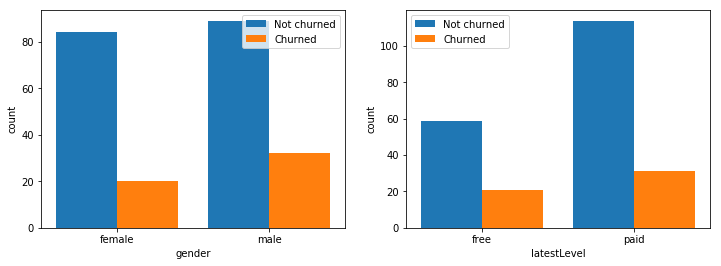

In [31]:
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
sns.countplot(x='gender', data=user_df_pd, hue='Churn', saturation=1);
plt.legend(['Not churned', 'Churned']);
plt.xticks([0,1], ['female','male'])


plt.subplot(1,2,2)
sns.countplot(x='latestLevel', data=user_df_pd, hue='Churn', saturation=1);
plt.legend(['Not churned', 'Churned'])
plt.xticks([0,1], ['free', 'paid'])

plt.savefig('gender_latest_level_count.pdf', dpi=150)

In [32]:
user_df.select(['gender', 'Churn']).groupBy('gender', 'Churn').count().show()

+------+-----+-----+
|gender|Churn|count|
+------+-----+-----+
|     1|    0|   89|
|     1|    1|   32|
|     0|    0|   84|
|     0|    1|   20|
+------+-----+-----+



In [33]:
user_df.select(['latestLevel', 'Churn']).groupBy('latestLevel', 'Churn').count().show()

+-----------+-----+-----+
|latestLevel|Churn|count|
+-----------+-----+-----+
|          1|    0|  114|
|          1|    1|   31|
|          0|    0|   59|
|          0|    1|   21|
+-----------+-----+-----+



We can see that the churn rates are only slightly higher for male users (female vs. male: 19.2% vs. 26.4%) and free users (free vs. paid: 26.3% vs. 21.4%). 

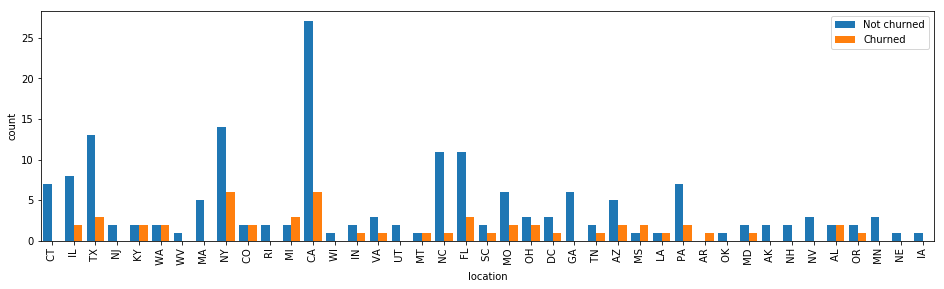

In [34]:
# plot location vs. churn
plt.figure(figsize = (16,4))
plt.subplots_adjust(top=0.95, bottom=0.15)
sns.countplot(x='location', data=user_df_pd, hue='Churn', saturation=1);
plt.xticks(rotation=90)
plt.legend(['Not churned', 'Churned'], loc='upper right');

plt.savefig('location_count.pdf', dpi=150)

We notice that the churn rates differ greatly among 41 states. For example, NC has a very low churn rate while there are more churned users than unchurned ones in MI and MS.

#### Analyze the relationship between each numerical feature and binary response

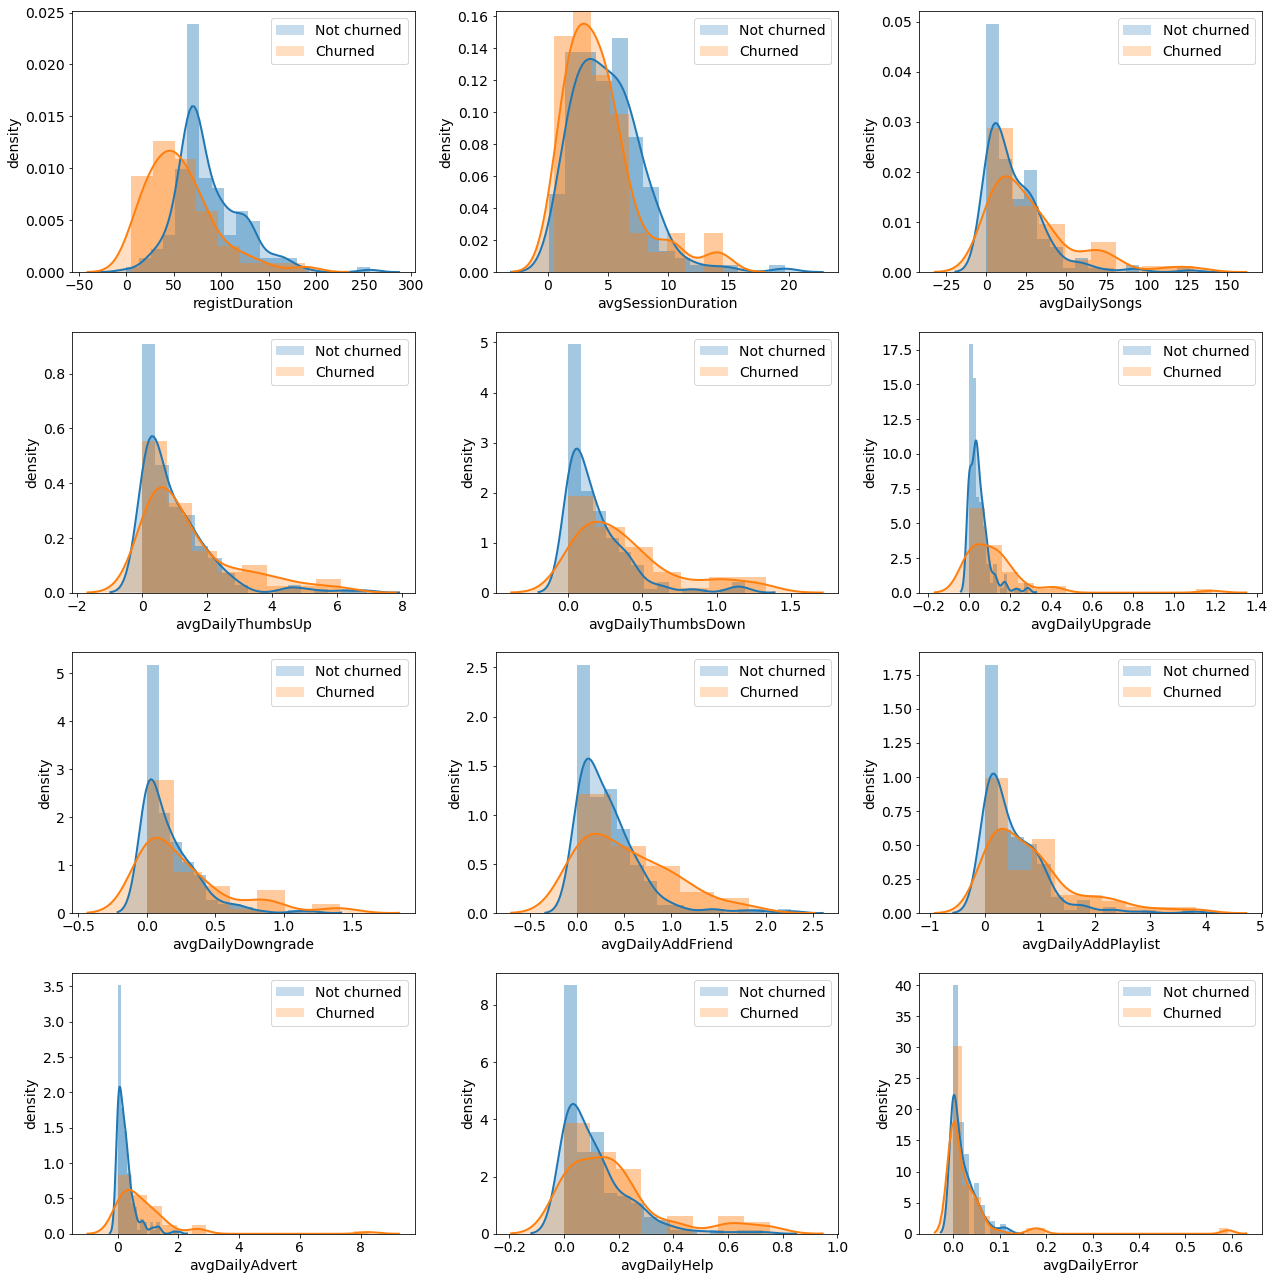

In [35]:
# plot numerical features vs. churn
col = ['registDuration', 'avgSessionDuration','avgDailySongs', 
       'avgDailyThumbsUp', 'avgDailyThumbsDown', 'avgDailyUpgrade', 
       'avgDailyDowngrade', 'avgDailyAddFriend','avgDailyAddPlaylist',
       'avgDailyAdvert', 'avgDailyHelp', 'avgDailyError']

plt.figure(figsize=(18,18))
with plt.style.context({'font.size': 14}): # change the font size temporarily
    for i in range(len(col)):
        plt.subplot(4,3,i+1)
        plt.tight_layout()
        sns.distplot(user_df_pd[user_df_pd['Churn'] == 0][col[i]], kde_kws={'shade':True, 'linewidth':2}, color='C0')
        sns.distplot(user_df_pd[user_df_pd['Churn'] == 1][col[i]], kde_kws={'shade':True, 'linewidth':2}, color='C1')
        plt.legend(['Not churned','Churned'])
        plt.xlabel(col[i])
        plt.ylabel('density')

plt.savefig('numerical_features_hist.pdf', dpi=150)

We find:

* Churned users have a shorter registration duration on average.
* Churned users give more thumbs down, need more help, and have to watch more advertisements per day.
* There is no significant difference between churned and unchurned users in terms of average session duration and average daily error.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Feature correlations

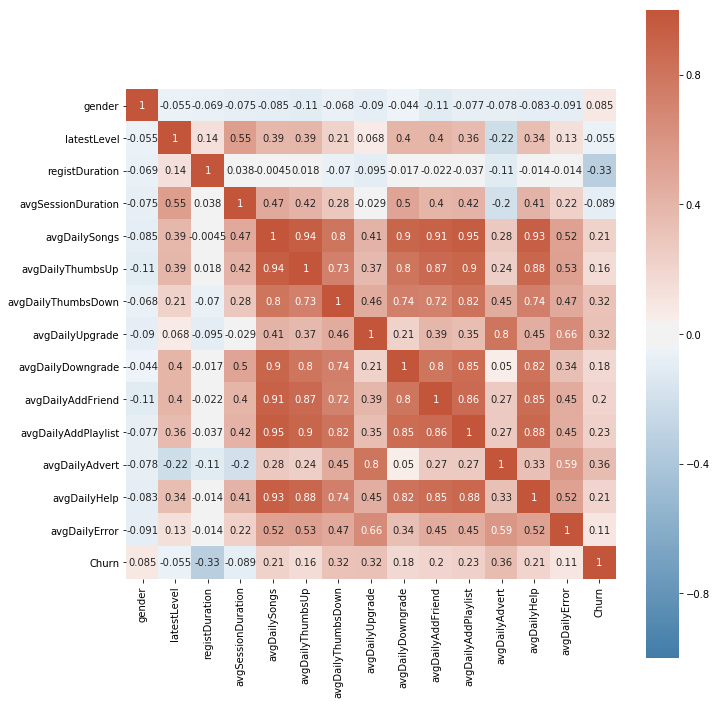

In [36]:
# calculate correlations across features (except 'location')
cor_mat = user_df_pd[['gender', 'latestLevel','registDuration', 'avgSessionDuration',
                     'avgDailySongs', 'avgDailyThumbsUp', 'avgDailyThumbsDown', 'avgDailyUpgrade', 
                     'avgDailyDowngrade', 'avgDailyAddFriend','avgDailyAddPlaylist',
                     'avgDailyAdvert', 'avgDailyHelp', 'avgDailyError', 'Churn']].corr()

# plot feature correlations
plt.figure(figsize=(10,10))
plt.subplots_adjust(left=0.15, right=1, top=0.95, bottom=0.05)
sns.heatmap(cor_mat, cmap=sns.diverging_palette(240, 20, as_cmap=True), annot=True, square=True, vmin=-1, vmax=1);
plt.savefig('feature_correlations.pdf', dpi=150)

From the heatmap above, we find
* There is a high correlation between most of the page event activities. For example, variables **avgDailySongs**, **avgDailyThumbsUp**, **avgDailyDowngrade**, **avgDailyAddFriend**, **avgDailyAddPlaylist** and **avgDailyHelp** are almost perfectly correlated. To avoid multicolinearity in the data, we only retain **avgDailyAddPlaylist** here (as it has the highest correlation with **Churn**). 

* **Churn** doesn not appear to have strong correlations with any features.  **registDuration** is negatively correlated with **Churn** while **avgDaily** has the highest positive correlation with **Churn**. It also shows that **gender**, **latestLevel**, **avgSessionDuration** and **avgDailyError** all have very low correlation with **Churn**. This is consistent with our previous findings through direct visualization. However, the Pearson correlation assumes a linear relationship, and a low correlation simply means that there is no linear relationship between these features and the response variable. The data might still have a nonlinear relationship and should be included in the modeling for now. 

In [37]:
feat_df = user_df.drop('userId', 'avgDailySongs', 'avgDailyThumbsUp', 
                       'avgDailyDowngrade', 'avgDailyAddFriend', 'avgDailyHelp')
feat_df.printSchema()

root
 |-- Churn: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- latestLevel: integer (nullable = true)
 |-- registDuration: integer (nullable = true)
 |-- avgSessionDuration: double (nullable = true)
 |-- avgDailyThumbsDown: double (nullable = true)
 |-- avgDailyUpgrade: double (nullable = true)
 |-- avgDailyAddPlaylist: double (nullable = true)
 |-- avgDailyAdvert: double (nullable = true)
 |-- avgDailyError: double (nullable = true)



#### Feature transformation

In [38]:
cat_cols=['gender', 'location', 'latestLevel']
label=['Churn']

# get numerical columns
num_cols = []
for field in feat_df.schema.fields :
    if field.name not in cat_cols + label:
        num_cols.append(field.name)

# convert categorical columns to index columns
indexers = [StringIndexer(inputCol=c, outputCol='{}_indexed'.format(c)) for c in cat_cols]
    
# one hot encode each categorical column by dummy numerical columns
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), 
                          outputCol='{}_encoded'.format(indexer.getOutputCol())) 
            for indexer in indexers]
    
# assemble numerical columns to a single vector column 
num_assembler = VectorAssembler(inputCols=num_cols, outputCol='num_features')
    
# scale each numberical feature within the range [0,1] 
scaler = MinMaxScaler(inputCol='num_features', outputCol='scaled_features')
    
# assemble all vector columns into one vector column
assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders] + ['scaled_features'], 
                            outputCol='features')

# create a pipeline with steps above 
data_pipeline = Pipeline(stages=indexers + encoders + [num_assembler, scaler, assembler])
model_df = data_pipeline.fit(feat_df).transform(feat_df)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

#### Train/Test data split

In [39]:
# Split the data into train, validation and test sets using stratified sampling based on 'Churn'
train_val = model_df.sampleBy('Churn', fractions={0: 0.8, 1: 0.8}, seed=2020)
test = model_df.subtract(train_val)
train = train_val.sampleBy('Churn', fractions={0: 0.75, 1: 0.75}, seed=2020)
val = train_val.subtract(train)
print('Train, validation and test sets include {}, {} and {} users, respectively.'
      .format(train.count(), val.count(), test.count()))

Train, validation and test sets include 161, 20 and 44 users, respectively.


As we can see the training and validation set do not have a 75/25 split. Spark's sampleBy function does not guarantee an exact split to the weights (fluctuations often happen if number of records is low). It only guarantees that each object has equal probability to be assigned to a specific subset.  

#### Training and evaluation

In [40]:
# logistic regression
start = time()
lr = LogisticRegression(featuresCol='features', labelCol='Churn')
lr_model = lr.fit(train)
end = time()
print('Total training time for logic regression: {:.1f} seconds'.format(end - start))

# random forest classifier
start = time()
rf = RandomForestClassifier(featuresCol='features', labelCol='Churn', seed=2020)
rf_model = rf.fit(train)
end = time()
print('Total training time for random forest classifier: {:.1f} seconds'.format(end - start))

# gradient-boosted tree classifier
start = time()
gb = GBTClassifier(featuresCol='features', labelCol='Churn', seed=2020)
gb_model = gb.fit(train)
end = time()
print('Total training time for gradient-boosted tree classifier: {:.1f} seconds'.format(end - start))

Total training time for logic regression: 130.8 seconds
Total training time for random forest classifier: 67.0 seconds
Total training time for gradient-boosted tree classifier: 267.9 seconds


#### Performance metrics

We choose to use the **f1 score** as a performance metric since our dataset is imbalanced. Another metric we look at is the **area under the precision-recall curve (AUC-PR)**. For binary classifier evaluation, precision-recall curves are more useful in practice than the receiver operating characteristic (ROC) curves for problems where the "positive" class is more of interest than the negative class. See: http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf 

In [41]:
model_dict = {'logistic regression': lr_model,
              'random forest classifier': rf_model,
              'gradient-boosted tree classifier': gb_model}

for model_name, model in model_dict.items():    
    # predict on validation set
    val_prediction = model.transform(val)
    
    # compute f1 score
    f1_score_evaluator = MulticlassClassificationEvaluator(labelCol='Churn', metricName='f1')
    f1_score = f1_score_evaluator.evaluate(val_prediction.select('Churn', 'prediction'))
    print('F1 score for {} on validation set: {:.3f}'.format(model_name, f1_score))
    
    # compute area under PR curve
    auc_evaluator = BinaryClassificationEvaluator(labelCol='Churn')
    auc_pr = auc_evaluator.evaluate(val_prediction, {auc_evaluator.metricName:'areaUnderPR'})
    print('Area under PR curve for {} on validation set: {:.3f}\n'.format(model_name, auc_pr))

F1 score for logistic regression on validation set: 0.659
Area under PR curve for logistic regression on validation set: 0.128

F1 score for random forest classifier on validation set: 0.811
Area under PR curve for random forest classifier on validation set: 0.460

F1 score for gradient-boosted tree classifier on validation set: 0.760
Area under PR curve for gradient-boosted tree classifier on validation set: 0.502



It shows that the random forest (RF) classifier outperforms both the logistic regression model and the gradient-boosted tree (GBT) classifier in terms of f1 score and training time. The GBT classifier only performs marginally better than the RF classifer in AUC-PR. As aforementioned, the features and the response variable do not follow a linear relationship, which might suggest that a non-linear model will be more suited to the data.

Next, we tune the random forest model to see if we can improve it further.

#### Hyperparameter tuning

In [42]:
# set hyperparameters for tuning
paramGrid = ParamGridBuilder() \
            .addGrid(rf.numTrees, [20, 40]) \
            .addGrid(rf.maxDepth, [4, 5, 6]) \
            .build()  

# grid search with cross validation    
crossval = CrossValidator(estimator = rf,
                          estimatorParamMaps = paramGrid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='Churn', metricName='f1'),
                          numFolds = 4)

start = time()
cv_rf = crossval.fit(train_val)
end = time()
print('Total training time for hyperparameter tuning on random forest classifier: {:.1f} seconds'.format(end - start))

Total training time for hyperparameter tuning on random forest classifier: 1182.5 seconds


In [43]:
# store grid search results in a dataframe
params = [{p.name: v for p, v in m.items()} for m in cv_rf.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['f1 score'] = cv_rf.avgMetrics
params_pd

,maxDepth,numTrees,f1 score
0,4,20,0.812351
1,5,20,0.808155
2,6,20,0.814149
3,4,40,0.802444
4,5,40,0.826485
5,6,40,0.805548


In [44]:
test_prediction = cv_rf.transform(test)

f1_score_evaluator = MulticlassClassificationEvaluator(labelCol='Churn', metricName='f1')
f1_score = f1_score_evaluator.evaluate(test_prediction.select('Churn', 'prediction'))
print('F1 score for tuned random forest classifier on test set: {:.3f}'.format(f1_score))

auc_evaluator = BinaryClassificationEvaluator(labelCol='Churn')
auc_pr = auc_evaluator.evaluate(test_prediction, {auc_evaluator.metricName:'areaUnderPR'})
print('Area under PR for tuned random forest classifier on test set: {:.3f}'.format(auc_pr))

F1 score for tuned random forest classifier on test set: 0.830
Area under PR for tuned random forest classifier on test set: 0.731


#### Feature importance

We extract feature importances from the trained model to gain a better understanding of the feature attributes to the model in predicting user churn.

In [45]:
# map features from the output of VectorAssembler back to the column names
attr_dict = test_prediction.schema['features'].metadata['ml_attr']['attrs']

# rename categorical columns
bin_attrs = [[attr["idx"], attr["name"]] for attr in attr_dict['binary']]
for bin_attr in bin_attrs:
    name_split = bin_attr[1].split('_')
    if name_split[0] == 'location':
        bin_attr[1] = name_split[0] + name_split[-1]
    else:
        bin_attr[1] = name_split[0]
        
# rename numerical columns
num_attrs = [[attr["idx"], attr["name"]] for attr in attr_dict['numeric']] 
num_attrs = [[num_attr[0], num_cols[i]] for i, num_attr in enumerate(num_attrs)]

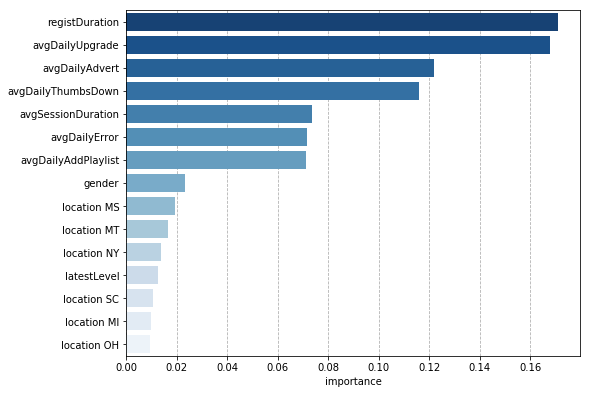

In [47]:
features = [attr[1] for attr in bin_attrs + num_attrs]
importances = list(cv_rf.bestModel.featureImportances)
feat_imp_pd = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending = False)

# plot feature importance
plt.figure(figsize=(9,6))
plt.subplots_adjust(left=0.20, right=0.9, top=0.95, bottom=0.15)
sns.barplot(data=feat_imp_pd.head(15), y="feature", x="importance", palette='Blues_r', zorder=2);
plt.grid(axis='x', linestyle='--', zorder=0)
plt.ylabel('');
plt.savefig('feature_importance.pdf', dpi=150)

It can be seen that the most important feature for identifying churned users is the registration duration which makes sense since it directly reflects a user's willness to stay with the service. Besides, average upgrades and thumbs down given per day that represent a user's strong inclination also play major roles in churn prediction. Another influential feature that helps churn detection is avarage daily advertisements. Intuitively, the more advertisements a user has to watch, the more likely he/she is dissatisfied with the service. 

The result also shows that gender, latest subscription level and each one-hot encoded location feature contribute little to predicting churned users. Nevertheless, we notice that all the top location features have much higher churn rates than the average churn rate.

# Conclusion

### Reflection

In this project, we managed to build a RF classifier that can accurately identify churned users. Since the dataset is relatively clean, the most critical step in the model development process is feature engineering. It has been proved most of the engineered features based on user behaviors play vital roles in churn prediction. 

As for model selection, the ensemble methods including RF and GBT classfiers, with comparable f1 scores and AUC-PRs, both outperform logistic regression. Considering the training time of the GBT classifier takes significantly longer than that of the RF classifier, we choose RF model for further tuning. The tune random forest model with 40 trees trained on 181 users has the f1 score improved compared to 20 trees, and achieves a score of 0.830 on a test set of 44 users. We expect the machine learning pipeline we develop here will generate better results with more training data in a full Sparkify dataset. 

### Improvement

There are a few aspects in the modeling that can be addressed for further improvements:
* Test more engineered features that capture user's activity patterns and trends
* Test features such as **userAgent** that are ignored so far
* Select less features to feed the model: Currently, we have 49 features for a dataset with only 225 sample, which may potentially cause the curse of dimensionality. From the analysis of feature importance, we can safely reduce the number of features by discarding most of encoded location featues.